### Main Config

In [1]:
# Data_path = "/content/drive/MyDrive/Behavioral/Data"
# Models_path = "/content/drive/MyDrive/Behavioral/Models"
Data_path = "D:/Projects/Fortune_company_opinion_mining/Data"
Models_path = "D:/Projects/Fortune_company_opinion_mining/Models"

random_seed = 42
notebook_env = "test" # "test" for experimenting, "final" for final execution

import os
import sys

### Google Colab Configs

In [2]:
# !pip uninstall -y pandas numpy scipy
# !pip install pandas scipy==1.10.1

In [3]:
# %%capture
# !pip install emoji
# !pip install langdetect
# !pip install nltk
# !pip install tqdm
# !pip install langid
# !pip install scipy==1.10.1
# !pip install genism
# !pip install pyLDAvis==3.4.1
# !pip install gensim
# !pip install scipy --upgrade

# Project

In [ ]:
import os
import pandas as pd
import spacy
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from langdetect import detect, detect_langs
import numpy as np
import pyLDAvis
import pyLDAvis.gensim
from sklearn.metrics import silhouette_score
import kagglehub
import os
import json
import textwrap
from corextopic import corextopic as ct
from gensim.models import LdaModel
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
tqdm.pandas()

### Defined functions

#### Input Output

In [5]:
def read_raw_main(Data_path):

    dataset_name = "10Mar2025.json"
    dataset_path = os.path.join(Data_path, dataset_name)

    if os.path.isfile(dataset_path):
        with open(dataset_path, 'r') as f:
            data = json.load(f)
        print("Dataset loaded from drive.")
    else:
        print("Downloading from Kaggle ...")
        fort_list_path = kagglehub.dataset_download("jarredgaudineer/social-media-posts-fortune-1000-companies")
        print("Dataset downloaded from kaggle.")

        # Load the wanted file
        temp_path = os.path.join(fort_list_path, "10Mar2025.json")
        
        with open(Data_path, 'r') as f:
            data = json.load(f)

        # Save the data into drive
        with open(dataset_path, 'w') as f:
            json.dump(data, f)
        print("Dataset saved to drive.")

    return data

def read_raw_complement():
    # The complementary Dataset
    dataset_name = "fortune1000_2024.csv.csv"
    dataset_path = os.path.join(Data_path, dataset_name)

    if os.path.isfile(dataset_path):
        fortune_company_list = pd.read_csv(dataset_path)
        print("Dataset loaded from drive.")
    else:
        fort_list_path = kagglehub.dataset_download("jeannicolasduval/2024-fortune-1000-companies")
        print("Dataset downloaded from kaggle.")
        fortune_company_list = pd.read_csv(os.path.join(fort_list_path, "fortune1000_2024.csv"))
        fortune_company_list.to_csv(dataset_path)
        print("Dataset saved to drive.")


def kaggle_save(dataset_name, data_path):
    print("Downloading from Kaggle ...")
    temp_path = kagglehub.dataset_download("khalilvandian/enriched-social-media-posts-fortune-1000-companies")
    temp_dataset_path = os.path.join(temp_path, dataset_name)

    enriched_data = pd.read_csv(temp_dataset_path)

    # Save to local data dir
    dataset_path = os.path.join(data_path, dataset_name)
    enriched_data.to_csv(dataset_path)

    return enriched_data


def read_enriched(data_path):
    dataset_name = "enriched_social-media-posts-fortune-1000-companies_data.csv"
    dataset_path = os.path.join(data_path, dataset_name)

    if os.path.isfile(dataset_path):
        enriched_data = pd.read_csv(dataset_path)
        print('Loaded file from data dir.')

    else:
        enriched_data = kaggle_save(dataset_name, data_path)

    return enriched_data

def read_preprocessed(data_path, notebook_env):

    if notebook_env == "test":
        dataset_name = "complete_preprocessed_companyData.csv"
    else:
        dataset_name = "complete_preprocessed_companyData_allData.csv"

    dataset_path = os.path.join(data_path, dataset_name)

    if os.path.isfile(dataset_path):
        temp_df = pd.read_csv(dataset_path, index_col=0)
        print("Dataset loaded from drive.")
        return temp_df
    else:
        return None
    
def read_tokenized(data_path, notebook_env):
    if notebook_env == "test":
        dataset_name = "spacy_tokenized_sample.pkl"
    else:
        dataset_name = "spacy_tokenized_allData.pkl"

    dataset_path = os.path.join(data_path, dataset_name)

    if os.path.isfile(dataset_path):
        tokenized_texts = pd.read_pickle(dataset_path)
        print("Loaded from drive.")
        return tokenized_texts
    else:
        return None

def load_lda_model(models_path):
    model_name = "GensimLdaModel_SpacyTokens_TopicCount20"
    # retrain with 20 topics or load back
    model_path_temp = os.path.join(models_path, model_name)

    if os.path.isfile(model_path_temp):
        lda_model = LdaModel.load(model_path_temp)
        return lda_model
    else:
        return None


#### Preprocessing

In [6]:
def preprocess_text(text, targets):

    # First Demojize Text
    edited_text = emoji.replace_emoji(text, '')

    # Mask company
    try:
        pattern = r'(?<![a-zA-Z])(?:' + '|'.join(re.escape(word) for word in targets if isinstance(word, str)) + r')(?![a-zA-Z])'
        if re.search(pattern, text, flags=re.IGNORECASE):
            edited_text = re.sub(pattern, "TargetedCompany", text, flags=re.IGNORECASE)
        else:
            edited_text = ""

    except Exception as e:
        raise

    # lower case
    edited_text = edited_text.lower()

    # remove links, mentions, hashtags
    edited_text = re.sub(r"http\S+|www\S+|@\w+|#\w+", '', edited_text)

    # Remove numbers
    edited_text = re.sub(r'\d+', '', edited_text)

    # Remove non ASCII
    edited_text = re.sub(r'[^\x00-\x7F]+', '', edited_text)

    # remove extra spaces
    edited_text = re.sub(r'\s+', ' ', edited_text).strip()

    # return if text is empty
    if edited_text == "":
        return edited_text

    # Remove non english
    try:
        # lang = detect(edited_text)
        lang, _ = langid.classify(edited_text)
        if lang != "en":
            edited_text = ""
    except Exception as e:
        # print(f"Error detecting language for text at index {index} and content:{edited_text}: {e}")
        edited_text = ""

    return edited_text

### Download Data from Kaggle/Load Data

In [7]:
# import sys

# # setting path
# sys.path.append('..')
# from src import ioFuncs

# ioFuncs.read_raw_main(Data_path=Data_path)

In [8]:
# columns = ["Company", "Text", "Source"]
# atts_temp = ["tweets", "comments", "posts"]
# source_dic = {"tweets": "Twitter", "comments": "Reddit-Comments", "posts": "Reddit-Posts"}
# mp_doc_list = []

# for company in data:
#   for text_list in atts_temp:
#     if text_list in company:
#       for text in company[text_list]:
#         mp_doc_list.append([company["company"], text["text"], source_dic[text_list]])


# data_df = pd.DataFrame(mp_doc_list, columns=columns)
# data_df

In [9]:
# enriched_data = pd.merge(fortune_company_list[["Company", "Ticker", "Sector", "Industry"]], data_df, left_on="Company", right_on="Company")
# enriched_data.sample(10, random_state=random_seed)

In [10]:
# # compare unique companies in the enriched dataset and main dataset
# enriched_companies = enriched_data["Company"].unique()
# main_companies = data_df["Company"].unique()

# print(f"Number of companies in the enriched dataset: {len(enriched_companies)}")
# print(f"Number of companies in the main dataset: {len(main_companies)}")

In [11]:
data_df = read_enriched(data_path=Data_path)
data_df = data_df.drop(data_df.columns[0], axis=1)
data_df.head()

Loaded file from data dir.


Company Ticker     Sector               Industry  \
0  Walmart    WMT  Retailing  General Merchandisers   
1  Walmart    WMT  Retailing  General Merchandisers   
2  Walmart    WMT  Retailing  General Merchandisers   
3  Walmart    WMT  Retailing  General Merchandisers   
4  Walmart    WMT  Retailing  General Merchandisers   

                                                Text   Source  
0  $GOOGL $GOOG $WMT Google And Walmart Payment A...  Twitter  
1  Can $PHNIX become the first meme coin to dethr...  Twitter  
2  Walmart $WMT \n\nThe Laughing Cow Cheese, 32 p...  Twitter  
3  Some of the most iconic businesses ever \n\n1....  Twitter  
4  Walmart $WMT currently has 1.05 Billion Square...  Twitter

In [12]:
for _, row in data_df.sample(random_state=2894, n=100).iterrows():
    print(row["Company"], ":")
    print(textwrap.fill(str(row["Text"]), width=120))
    print("="*120)

NVR :
Dealing with a strange issue that I can't seem to figure out how to resolve. I have most of my cameras connected to my
POE Switch so I can record to the SD Card and to my NVR and have separate settings. This was before the Hy-bridge mode
feature. UID is enabled on all my cameras.     The only device giving me an issue out of nowhere is my WIFI Doorbell
(White Variant). For whatever reason I cannot view the camera independently from the NVR when my phone is connected to
WIFI. Works fine when viewing it through the NVR via my phone (While connected to WIFI). I've tried rebooting my
Decos/Modem, Factory reset the doorbell. The issue still persists. If I disconnect my phone off my WIFI I can view the
doorbell independently from the NVR with no issue. When Phone is connected to WIFI The Doorbell just shows "Connection
failed"
https://preview.redd.it/fsej41ufemfe1.jpg?width=1079&format=pjpg&auto=webp&s=1b0a76430c0b0c2ed9eedf7f485ca10ec07a6487
Am I dealing with an Android APP Glitch? I'

## Exploration

In [13]:
data_df.describe()

Company  Ticker      Sector                         Industry  \
count   591347  579881      591347                           591347   
unique     953     932          21                               75   
top      Tesla    TSLA  Technology  Internet Services and Retailing   
freq      9438    9438      132908                            60577   

                                                     Text        Source  
count                                              509032        591347  
unique                                             487444             3  
top     Welcome to the community! Please ensure that y...  Reddit-Posts  
freq                                                  334        329493

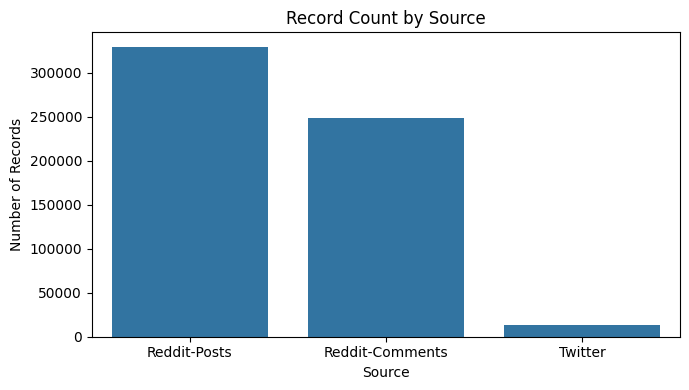

In [14]:
# Bar chart of source counts in data_df
source_counts = data_df['Source'].value_counts()
plt.figure(figsize=(7, 4))
sns.barplot(x=source_counts.index, y=source_counts.values)
plt.title('Record Count by Source')
plt.xlabel('Source')
plt.ylabel('Number of Records')
plt.tight_layout()
plt.show()

In [15]:
top_company_counts = (
    data_df.groupby(['Company', 'Sector'])
    .size()
    .reset_index(name='TotalCount')
    .sort_values('TotalCount', ascending=False)
)

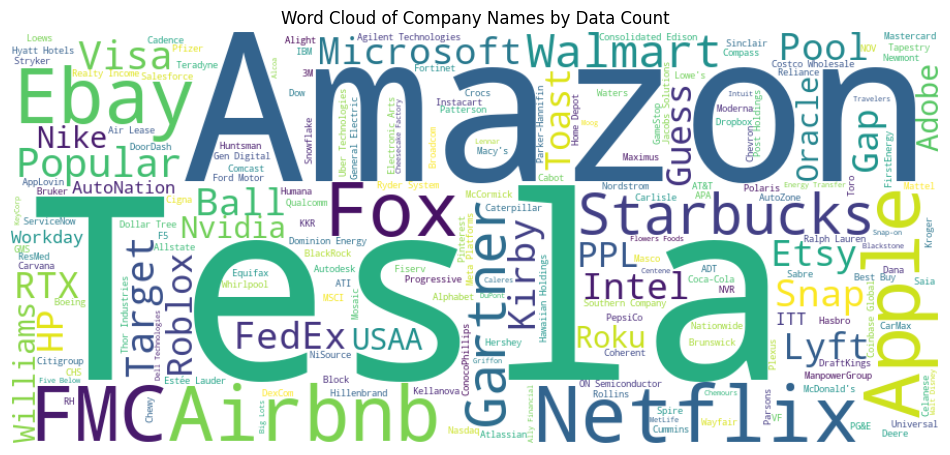

In [16]:
# Create a dictionary of company names and their data counts
company_counts_dict = top_company_counts.set_index('Company')['TotalCount'].to_dict()

# Generate the word cloud
company_wordcloud = WordCloud(width=900, height=400, background_color="white").generate_from_frequencies(company_counts_dict)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(company_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Company Names by Data Count")
plt.show()

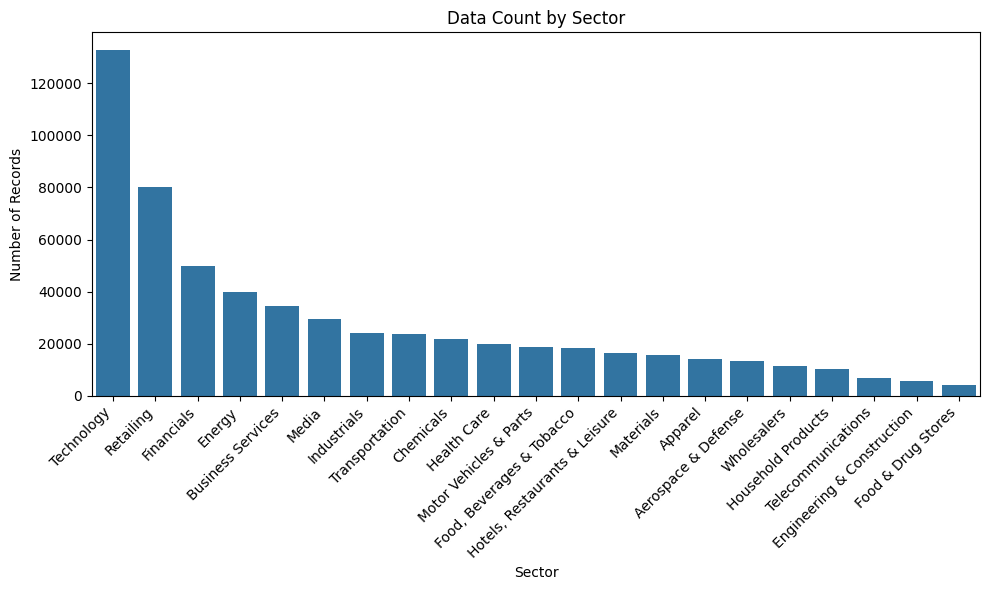

In [17]:
# Bar chart: Sector vs. Data Count
sector_counts = data_df['Sector'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=sector_counts.index, y=sector_counts.values)
plt.title('Data Count by Sector')
plt.xlabel('Sector')
plt.ylabel('Number of Records')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Preprocessing the texts

In [18]:
# show duplicates
# duplicates = data_df[data_df.duplicated()]
# duplicates.sample(min(10, len(duplicates)), random_state=random_seed)

In [19]:
temp_df = read_preprocessed(data_path=Data_path, notebook_env=notebook_env)

if temp_df is None:
  # drop duplicates
  temp_df = data_df.drop_duplicates()
  temp_df.describe()

  ### Sample for Analysis
  # **Sampling of Enriched Data**: This is done to make experiments lighter, for final analysis all data will be used.
  if notebook_env == "test":
    sample_data_df = data_df.sample(50000, random_state=random_seed)
  elif notebook_env == "final":
    sample_data_df = data_df.copy()

  temp_df = sample_data_df.copy()

  def prprcss(row):
    try:
      return preprocess_text(row["Text"], [row["Company"], row["Ticker"]])
    except:
      print(row.to_markdown())
    

  temp_df["Text"] = temp_df.progress_apply(lambda row: prprcss(row), axis=1)
  temp_df

  temp_df = temp_df[temp_df["Text"] != ""]
  temp_df.describe()

  temp_df.to_csv(dataset_path)
  print("File saved to drive.")

else:
  print(temp_df.head())


Dataset loaded from drive.
         Company Ticker              Sector            Industry  \
52944    Comcast  CMCSA  Telecommunications  Telecommunications   
143656       Dow    DOW           Chemicals           Chemicals   
525390  Sinclair   SBGI               Media       Entertainment   
374514      Olin    OLN           Chemicals           Chemicals   
178759        3M    MMM           Chemicals           Chemicals   

                                                     Text           Source  
52944   same thing happened to me this week. police de...  Reddit-Comments  
143656  > stock futures tumbled sunday night to kick o...     Reddit-Posts  
525390  got some big names in the mid and fwd, feel my...     Reddit-Posts  
374514  not full true! i was playing with targetedcomp...  Reddit-Comments  
178759  this storm had to be some kind of divine punis...     Reddit-Posts  


In [20]:
temp_df

Company Ticker                     Sector            Industry  \
52944    Comcast  CMCSA         Telecommunications  Telecommunications   
143656       Dow    DOW                  Chemicals           Chemicals   
525390  Sinclair   SBGI                      Media       Entertainment   
374514      Olin    OLN                  Chemicals           Chemicals   
178759        3M    MMM                  Chemicals           Chemicals   
...          ...    ...                        ...                 ...   
374380      Olin    OLN                  Chemicals           Chemicals   
475737   Cadence   CDNS                 Technology   Computer Software   
330705  Seaboard    SEB  Food, Beverages & Tobacco     Food Production   
390582  Huntsman    HUN                  Chemicals           Chemicals   
414291  Autodesk   ADSK                 Technology   Computer Software   

                                                     Text           Source  
52944   same thing happened to me this week. police de...  Reddit-Comments  
143656  > stock futures tumbled sunday night to kick o...     Reddit-Posts  
525390  got some big names in the mid and fwd, feel my...     Reddit-Posts  
374514  not full true! i was playing with targetedcomp...  Reddit-Comments  
178759  this storm had to be some kind of divine punis...     Reddit-Posts  
...                                                   ...              ...  
374380  gpa- fine, adequate for anywhere sat is on the...  Reddit-Comments  
475737  is anyone else besides me sick and tired of th...     Reddit-Posts  
330705  hello r/trains, im doing a painting for th ann...     Reddit-Posts  
390582  targetedcompany is a backline control hero on ...     Reddit-Posts  
414291  company: targetedcompany location: british col...     Reddit-Posts  

[35192 rows x 6 columns]

In [21]:
temp_df.head()

Company Ticker              Sector            Industry  \
52944    Comcast  CMCSA  Telecommunications  Telecommunications   
143656       Dow    DOW           Chemicals           Chemicals   
525390  Sinclair   SBGI               Media       Entertainment   
374514      Olin    OLN           Chemicals           Chemicals   
178759        3M    MMM           Chemicals           Chemicals   

                                                     Text           Source  
52944   same thing happened to me this week. police de...  Reddit-Comments  
143656  > stock futures tumbled sunday night to kick o...     Reddit-Posts  
525390  got some big names in the mid and fwd, feel my...     Reddit-Posts  
374514  not full true! i was playing with targetedcomp...  Reddit-Comments  
178759  this storm had to be some kind of divine punis...     Reddit-Posts

## Vectorization and Lemmatization

In [22]:
target_filter = "targetedcompany"
nlp_pip = spacy.load("en_core_web_sm")

def tokenize_text(text):

  # tokenize with NLTK
  doc = nlp_pip(text)

  # remove punct and stopwords and targetCompany
  tokens = []
  for token in doc:
    if (not token.is_punct) and (not token.is_stop) and (token.text != target_filter):
      tokens.append(token.lemma_)

  return tokens

# def edit_tokens(doc_list):

#   # remove punct and stopwords and targetCompany
#   tokens = []
#   for token in doc_list:
#     if (not token.is_punct) and (not token.is_stop) and (token.text != target_filter):
#       tokens.append(token.lemma_)

#   return tokens

In [23]:
# # tesing the tokenization
# sample = temp_df.sample(random_state=random_seed, n= 100)[["Text"]]
# sample["Tokens"] = sample[["Text"]].apply(lambda row: tokenize_text(row["Text"]), axis=1)
# sample

In [24]:
# def print_tokenization(row):
#   test = textwrap.fill(row["Text"], width=150)
#   tokenized = textwrap.fill(", ".join(row["Tokens"]), width=150)
#   print(f"Main text: {test}, \n **************** \nTokenized Text: {tokenized}\n")


# sample.apply(lambda row: print_tokenization(row), axis=1)

In [25]:

# temp = temp_df.sample(100, random_state=random_seed)["Text"]
# listOfDocs = list(tqdm(nlp_pip.pipe(temp), total=len(temp)))
# listOfTokens = pd.Series([token for token in listOfDocs])
# tokenized_texts = listOfTokens.progress_apply(lambda x: edit_tokens(x))

In [26]:
tokenized_texts = read_tokenized(Data_path, notebook_env)

if tokenized_texts is None:
  # # pass the texts through the spacy pipeline in a statistical manner
  # docGenerators = tqdm(nlp_pip.pipe(temp_df["Text"], batch_size=500), total=len(temp_df["Text"]))
  # listOfDocs = list(docGenerators)

  # # use generator to extract tokens
  # listOfTokens = pd.Series([token for token in listOfDocs])
  # tokenized_texts = listOfTokens.progress_apply(lambda x: edit_tokens(x))

  tokenized_texts = temp_df.progress_apply(lambda row: tokenize_text(row["Text"]), axis=1)
  tokenized_texts.to_pickle(dataset_path)
  print("Saved to drive.")

Loaded from drive.


In [27]:
tokenized_texts

0        [thing, happen, week, police, dept, say, call,...
1        [>, stock, future, tumble, sunday, night, kick...
2        [get, big, name, mid, fwd, feel, defence, ligh...
3        [true, play, early, hold, pretty, obviously, g...
4        [storm, kind, divine, punishment, cosmic, god,...
                               ...                        
35187    [gpa-, fine, adequate, sit, low, end, probably...
35188                 [sick, tired, talk, like, wtf, stop]
35189    [hello, r, train, m, painting, th, anniversary...
35190    [backline, control, hero, red, team, available...
35191    [company, location, british, columbia, salary,...
Length: 35192, dtype: object

In [28]:
def identical_analyzer(token):
  return token

vectorizer = CountVectorizer(analyzer=identical_analyzer, min_df=0.005, max_df=0.995)
bow = vectorizer.fit_transform(tokenized_texts)

In [29]:
len(vectorizer.vocabulary_)

1622

In [30]:
# dict of terms and their frequencies
term_frequencies = {}
feats = vectorizer.get_feature_names_out()
freqs = bow.toarray().sum(axis=0)

for feature, frequency in zip(feats, freqs):
  term_frequencies[feature] = frequency

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(term_frequencies)

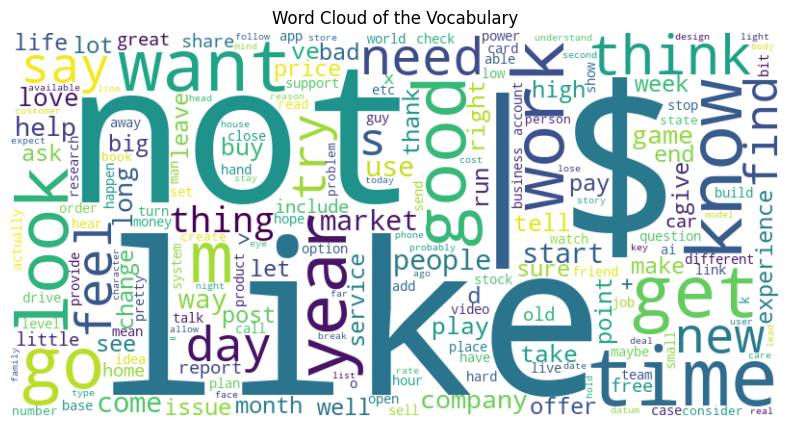

In [31]:
# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f"Word Cloud of the Vocabulary")
plt.show()

## Topic Modeling The texts
Initially, we need to understand what sort of content we have. This will help deciding if we should go with data based topics or anchored topics.

In [32]:
dictionary = Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

In [33]:
# topic_counts = range(2,30,2)

In [34]:
# models = []
# c_v_coherence = []

# for i in tqdm(topic_counts):
#   # check if model is already in drive
#   model_path_temp = os.path.join(Models_path, "GensimLdaModel_SpacyTokens_TopicCount" + str(i))

#   if os.path.isfile(model_path_temp):
#     lda_model = LdaModel.load(model_path_temp)
#   else:
#     lda_model = LdaModel(
#         corpus=corpus,
#         id2word=dictionary,
#         num_topics=i,
#         random_state=random_seed,
#         passes=10,
#         iterations=50
#     )

#     # save the trained model
#     lda_model.save(model_path_temp)

#   # append the model to a list
#   models.append(lda_model)


#   cm = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
#   c_v_coherence.append(cm.get_coherence())

# metrics = pd.DataFrame({"Topic_Count": list(topic_counts), "c_v": c_v_coherence})
# metrics.head()

In [35]:
# # plot coherence by the topic count
# import matplotlib.pyplot as plt

# plt.plot(metrics["Topic_Count"], metrics["c_v"], marker='o')
# plt.xlabel('Number of Topics')
# plt.ylabel('Coherence Score')
# plt.title('C_V Coherence Score vs. Number of Topics')

# for i, txt in enumerate(metrics["Topic_Count"]):
#   plt.text(metrics["Topic_Count"][i], metrics["c_v"][i], f'{txt}', ha='left', va='bottom') # Format label to 2 decimal places


- 1: ranting probably
- 2: Intimate fiction
- 3: Personal growth
- 4: Jobs (Mostly tech jobs)
- 5: Financial Markets
- 6: Personal finance
- 7: Potentially daily stories and personal narratives?!
- 8: Health issues
- 9: Online stores - Purchases
- 10: Gaming
- 11: Computer technology (similar to 15)
- 12: Company news / Market news
- 13: Political news and posts
- 14: Streaming channels and relevant content (YT, Prime, ...)
- 15: Computer technology and gaming hardware
- 16: Books, Movies, Fiction, ...
- 17: Subreddit moderaters and banners in reddit
- 18: Company applications and policies
- 19: Gaming
- 20: Lifestyle

In [36]:
lda_model = load_lda_model(Models_path)

if lda_model is None:
  # lda_model = LdaModel(
  #     corpus=corpus,
  #     id2word=dictionary,
  #     num_topics=20,
  #     random_state=random_seed,
  #     passes=10,
  #     iterations=50
  # )
  # # save the trained model
  # lda_model.save(model_path_temp)
  print("Trained model.")

pyLDAvis.enable_notebook()
# # top_model_index = metrics[metrics["Topic_Count"] == 20].index[0]
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds="mmds", R=50)

d:\Projects\Fortune_company_opinion_mining\venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.064568  0.384031       1        1  23.772012
13     0.202398  0.358173       2        1   9.723552
2     -0.102749  0.368151       3        1   8.384601
12    -0.222454  0.179049       4        1   6.704488
15    -0.339257  0.090155       5        1   6.277585
14    -0.269343  0.299665       6        1   5.144641
4      0.331210  0.253573       7        1   4.717422
18    -0.084917  0.050949       8        1   4.662751
0      0.013462  0.190928       9        1   4.450746
3      0.236556  0.104525      10        1   4.400016
5     -0.017400 -0.161242      11        1   3.112514
10    -0.340853 -0.162900      12        1   3.107484
19    -0.437882 -0.056785      13        1   2.794187
9      0.191995 -0.153315      14        1   2.540940
8      0.251966 -0.391136      15        1   2.517355
6      0.383724 -0.165035      16        1   2.473189
16     0.409296 -0.010511      17        1   2.093947
1      0.056555 -0.409985      18        1   1.274038
11    -0.230224 -0.337997      19        1   1.169010
17    -0.096651 -0.430293      20        1   0.679520, topic_info=         Term          Freq         Total Category  logprob  loglift
959         $  21016.000000  21016.000000  Default  50.0000  50.0000
3910        |  11402.000000  11402.000000  Default  49.0000  49.0000
659       not  15913.000000  15913.000000  Default  48.0000  48.0000
1837   market   5605.000000   5605.000000  Default  47.0000  47.0000
1134        +   3900.000000   3900.000000  Default  46.0000  46.0000
...       ...           ...           ...      ...      ...      ...
1124  walmart     63.832045    194.554832  Topic20  -5.5079   3.8771
298     limit     93.416151   1101.195389  Topic20  -5.1270   2.5245
505   vanilla     57.864489    141.125864  Topic20  -5.6060   4.1000
1233   credit     71.680724   1449.128479  Topic20  -5.3919   1.9850
2856     rare     55.449770    254.644746  Topic20  -5.6486   3.4671

[2214 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
959        5  0.198372        $
959       12  0.003378        $
959       15  0.798197        $
1134       4  0.006410        +
1134       5  0.002051        +
...      ...       ...      ...
3910      15  0.999895        |
4439      15  0.989836  |:-|:-|
12993     14  0.992403      |ye
12994     14  0.982011     |yes
2494      17  0.991421       ||

[5564 rows x 3 columns], R=50, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 14, 3, 13, 16, 15, 5, 19, 1, 4, 6, 11, 20, 10, 9, 7, 17, 2, 12, 18])

In [37]:
# topics = {
#     1: "ranting probably",
#     2: "Intimate fiction",
#     3: "Personal growth",
#     4: "Jobs (Mostly tech jobs)",
#     5: "Financial Markets",
#     6: "Personal finance",
#     7: "Potentially daily stories and personal narratives?!",
#     8: "Health issues",
#     9: "Online stores - Purchases",
#     10: "Gaming",
#     11: "Computer technology (similar to 15)",
#     12: "Company news / Market news",
#     13: "Political news and posts",
#     14: "Streaming channels and relevant content (YT, Prime, ...)",
#     15: "Computer technology and gaming hardware",
#     16: "Books, Movies, Fiction, ...",
#     17: "Subreddit moderaters and banners in reddit",
#     18: "Company applications and policies",
#     19: "Gaming",
#     20: "Lifestyle"
# }

# def select_topics(topic_list):
#     threshold = 0.1
#     topic_dic = {}
#     for topic_id, topic_score in topic_list:
#         topic_name = topics[topic_id + 1]

#         if topic_score >= threshold:
#             topic_dic[topic_name] = topic_score
    
#     if len(topic_dic) == 0:
#         return None
    
#     return topic_dic


# doc_topics.sample(10).apply(lambda x: select_topics(x))

### Eval and vis

In [38]:
# # Count topics
# topic_counts = temp_df["Topic"].value_counts().sort_index()

# # Map the index to topic titles for labeling
# labels = [topic_titles[i] for i in topic_counts.index]

# # Plot with titles as x-axis labels
# plt.figure(figsize=(10, 6))
# plt.bar(labels, topic_counts.values)
# plt.xticks(rotation=45, ha='right')
# plt.title("Document Counts per Topic")
# plt.ylabel("Number of Documents")
# plt.tight_layout()
# plt.show()

In [39]:
# # Group data by sector and topic, and count occurrences
# sector_topic_counts = temp_df.groupby(['Sector', 'Topic'])['Topic'].count().unstack()

# # Get sector and topic labels
# sectors = sector_topic_counts.index
# topic_labels = [topic_titles[i] for i in range(lda.n_components)]

# # Create the stacked bar chart
# fig, ax = plt.subplots(figsize=(12, 6))

# # Plot bars for each topic within each sector
# bottom = [0] * len(sectors)  # Initialize bottom for stacking
# for i, topic_label in enumerate(topic_labels):
#     ax.bar(sectors, sector_topic_counts[i], label=topic_label, bottom=bottom)
#     bottom = [bottom[j] + sector_topic_counts[i][j] for j in range(len(sectors))]

# # Set chart labels and formatting
# ax.set_xlabel("Sector")
# ax.set_ylabel("Number of Documents")
# ax.set_title("Topic Distribution Across Sectors")
# ax.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
# plt.tight_layout()
# plt.show()

In [40]:
# # Assuming your DataFrame is named 'temp_df' and contains 'Source' and 'Topic' columns

# # Group data by source and topic, and count occurrences
# source_topic_counts = temp_df.groupby(['Source', 'Topic'])['Topic'].count().unstack()

# # Get source and topic labels
# sources = source_topic_counts.index
# topic_labels = [topic_titles[i] for i in range(lda.n_components)]  # Assuming you have topic_titles defined

# # Create the stacked bar chart
# fig, ax = plt.subplots(figsize=(12, 6))

# # Plot bars for each topic within each source
# bottom = [0] * len(sources)  # Initialize bottom for stacking
# for i, topic_label in enumerate(topic_labels):
#     ax.bar(sources, source_topic_counts[i], label=topic_label, bottom=bottom)
#     bottom = [bottom[j] + source_topic_counts[i][j] for j in range(len(sources))]

# # Set chart labels and formatting
# ax.set_xlabel("Source")
# ax.set_ylabel("Number of Documents")
# ax.set_title("Topic Distribution Across Sources")
# ax.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
# plt.tight_layout()
# plt.show()

In [41]:
# # Get feature names (words) from the vectorizer
# feature_names = vectorizer.get_feature_names_out()

# # Create a dictionary to store the word clouds for each topic
# topic_wordclouds = {}

# # Iterate through each topic
# for topic_index in range(lda.n_components):
#     # Get documents belonging to the current topic
#     topic_documents = temp_df[temp_df["Topic"] == topic_index]["Text"]

#     # Create a frequency dictionary for words in the topic documents
#     word_frequencies = {}
#     for doc in topic_documents:
#         for word in tokenize_text(doc):  # Use your tokenize_text function
#             if word in feature_names:
#                 word_frequencies[word] = word_frequencies.get(word, 0) + 1

#     # Create a WordCloud object
#     wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_frequencies)

#     # Store the word cloud in the dictionary
#     topic_wordclouds[topic_index] = wordcloud

#     # Display the word cloud
#     plt.figure(figsize=(10, 5))
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.title(f"Word Cloud for Topic {topic_index}: {topic_titles[topic_index]}")  # Assuming you have topic_titles
#     plt.show()


## Anchored Topic Modeling of Documents

### Setup All Docs for Topic Selection

In [42]:
notebook_env_clust = "final"

In [43]:
docs_df = read_preprocessed(data_path=Data_path, notebook_env=notebook_env_clust)

Dataset loaded from drive.


In [44]:
company_counts = docs_df["Company"].value_counts()
print(company_counts.head(5))

Company
Tesla     6841
Amazon    6378
FMC       6350
Apple     5558
Airbnb    5194
Name: count, dtype: int64


In [45]:
tokenized_texts_clust = read_tokenized(Data_path, notebook_env_clust)
tokenized_texts_clust_sample = tokenized_texts_clust.sample(n=int(len(tokenized_texts_clust)/10), random_state=random_seed)

Loaded from drive.


In [46]:
def identical_analyzer(token):
  return token

vectorizer_clust = CountVectorizer(analyzer=identical_analyzer, min_df=0.005, max_df=0.995)
bow_clust = vectorizer_clust.fit_transform(tokenized_texts_clust)
vocab_clust = vectorizer_clust.get_feature_names_out()

bow_clust_sample = vectorizer_clust.fit_transform(tokenized_texts_clust_sample)
vocab_clust_sample = vectorizer_clust.get_feature_names_out()

In [47]:
len(vectorizer_clust.vocabulary_)

1610

### Semi Supervised Topic Modeling

In [59]:
# 2) Define your 5 anchored topic word‑lists
anchors = [
    # Politics
    ['election', 'government', 'president', 'conservative', 'republican', 'nation', 'military', 'administration', 'political'],

    # Lifestyle and Health
    ['doctor', 'health', 'issue', 'symptom', 'disease', 'patient'],

    # Financial markets
    ['stock', 'market', 'investing', 'share', 'portfolio', 'price', 'credit', 'account', 'deposit', 'shareholder'],

    # Customer Review
    ['design', 'price', 'brand', 'quality', 'review', 'rate', 'feature', 'product', 'budget'],

    # Job postings
    ['job', 'career', 'hiring', 'resume', 'linkedin', 'apply', "interview", "submit"]
]

# 3) Decide how many “free” topics (to ignore later)
n_free_topics = 6

# 4) Instantiate and fit Corex
corex_model = ct.Corex(n_hidden=len(anchors) + n_free_topics, seed=42)
corex_model.fit(
    bow_clust,
    words=vocab_clust,
    anchors=anchors,
    anchor_strength=12
)

# 5) Get the per-doc, per-topic probability matrix
#    transform(..., details=True) returns (p_y_given_x, log_z)
probs, _ = corex_model.transform(bow_clust, details=True)  # shape = (n_docs, n_hidden)

# 6) Keep only the first 5 columns (our anchored topics)
anchor_probs = probs[:, :len(anchors)]                # shape = (n_docs, 5)

# 7) For each doc, find best anchor and its probability
best_idx  = anchor_probs.argmax(axis=1)               # values in {0,1,2,3,4}
best_prob = anchor_probs.max(axis=1)                  # floats in [0,1]

# 8) Add these predictions back into your DataFrame
docs_df['pred_topic'] = best_idx
docs_df['pred_prob']  = best_prob

# 9) Filter by a confidence threshold (e.g. >0.5)
threshold = 0.5
filtered_df = docs_df[docs_df['pred_prob'] > threshold].copy()

# 10) (Optional) Map numeric codes to human-readable labels
topic_names = {
    0: 'Politics',
    1: 'Health',
    2: 'FinMkts',
    3: 'CustRev',
    4: 'Jobs'
}
filtered_df['pred_topic_name'] = filtered_df['pred_topic'].map(topic_names)

In [60]:
filtered_df.head()

Company Ticker     Sector               Industry  \
0   Walmart    WMT  Retailing  General Merchandisers   
18  Walmart    WMT  Retailing  General Merchandisers   
32  Walmart    WMT  Retailing  General Merchandisers   
35  Walmart    WMT  Retailing  General Merchandisers   
40  Walmart    WMT  Retailing  General Merchandisers   

                                                 Text           Source  \
0   $googl $goog $targetedcompany google and targe...          Twitter   
18  check out the season champs! they dominated th...          Twitter   
32  i've heard about targetedcompany's weird teamw...  Reddit-Comments   
35   i never have issues with targetedcompany babies!  Reddit-Comments   
40  i've never had any issues shopping at sparkman...  Reddit-Comments   

    pred_topic  pred_prob pred_topic_name  
0            2   0.999999         FinMkts  
18           2   0.999999         FinMkts  
32           4   0.999999            Jobs  
35           1   0.999999          Health  
40           1   0.999999          Health

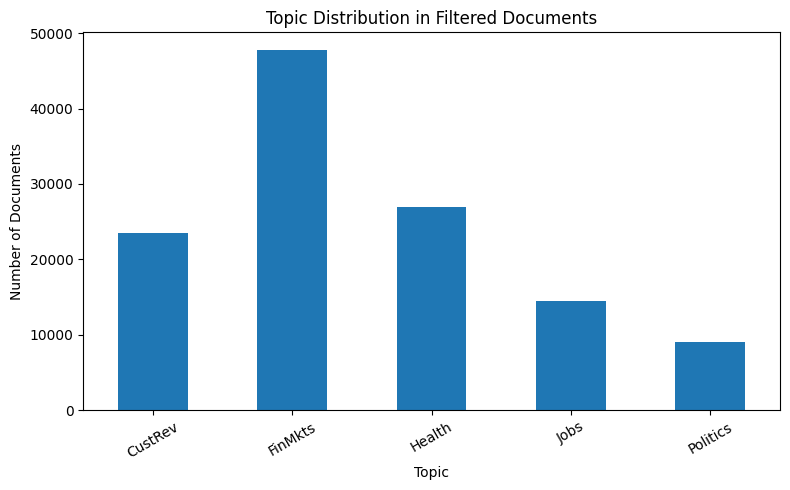

In [61]:
import matplotlib.pyplot as plt

topic_counts = filtered_df['pred_topic_name'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
topic_counts.plot(kind='bar')
plt.xlabel('Topic')
plt.ylabel('Number of Documents')
plt.title('Topic Distribution in Filtered Documents')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [52]:
import itertools

In [ ]:
# ---------- USER CONFIG ----------
ANCHORS = anchors                   # your existing list of anchor word lists
TEXTS   = tokenized_texts_clust_sample     # list[list[str]]
VOCAB   = vocab_clust_sample               # from CountVectorizer
BOW     = bow_clust_sample                 # sparse matrix (n_docs x n_vocab)

TOP_N_WORDS = 10
K_FREE_GRID = [2, 4, 6, 8]
ANCHOR_STRENGTH_GRID = [2, 5, 8, 12]
SEED = 42

SHOW_TC_PLOT = True        # set False to skip TC plot
SAVE_PLOTS = False         # set True to save figures
OUTDIR = "corex_tuning_plots"
# ---------------------------------

# Dictionary for coherence (keep simple; ensure anchors retained)
dictionary = corpora.Dictionary(TEXTS)

def get_topic_wordlists(model, n_words=10):
    raw = model.get_topics(n_words=n_words)
    return [[tpl[0] for tpl in topic] for topic in raw]

def coherence_mean(wordlists, texts, dictionary):
    if not wordlists:
        return np.nan
    cm = CoherenceModel(
        topics=wordlists,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    return cm.get_coherence()

# Prepare grid
grid = list(itertools.product(K_FREE_GRID, ANCHOR_STRENGTH_GRID))
results = []

pbar = tqdm(grid, desc="Tuning CorEx", unit="config")

for k_free, a_strength in pbar:
    n_hidden = len(ANCHORS) + k_free
    # Update progress bar postfix
    pbar.set_postfix(k_free=k_free, strength=a_strength)

    model = ct.Corex(n_hidden=n_hidden, seed=SEED)
    model.fit(
        BOW,
        words=VOCAB,
        anchors=ANCHORS,
        anchor_strength=a_strength
    )

    wordlists = get_topic_wordlists(model, n_words=TOP_N_WORDS)
    anchored_wordlists = wordlists[:len(ANCHORS)]
    free_wordlists = wordlists[len(ANCHORS):]

    cv_anchored_mean = coherence_mean(anchored_wordlists, TEXTS, dictionary)
    cv_all_mean = coherence_mean(wordlists, TEXTS, dictionary)

    results.append({
        'k_free': k_free,
        'anchor_strength': a_strength,
        'cv_anchored_mean': cv_anchored_mean,
        'cv_all_mean': cv_all_mean,
        'tc_total': getattr(model, 'tc', np.nan)
    })

df = pd.DataFrame(results)
print("\nGrid Results:")
print(df.sort_values(['cv_anchored_mean', 'k_free'], ascending=[False, True]).reset_index(drop=True))



Tuning CorEx:   0%|          | 0/16 [00:00<?, ?config/s, k_free=2, strength=2]

Tuning CorEx:   6%|▋         | 1/16 [00:46<11:43, 46.89s/config, k_free=2, strength=5]

Tuning CorEx:  12%|█▎        | 2/16 [01:31<10:36, 45.48s/config, k_free=2, strength=8]

Tuning CorEx:  19%|█▉        | 3/16 [02:15<09:45, 45.05s/config, k_free=2, strength=12]

Tuning CorEx:  25%|██▌       | 4/16 [03:00<08:57, 44.79s/config, k_free=4, strength=2] 

Tuning CorEx:  31%|███▏      | 5/16 [03:47<08:22, 45.72s/config, k_free=4, strength=5]

Tuning CorEx:  38%|███▊      | 6/16 [04:33<07:37, 45.71s/config, k_free=4, strength=8]

Tuning CorEx:  44%|████▍     | 7/16 [05:21<06:58, 46.46s/config, k_free=4, strength=12]

Tuning CorEx:  50%|█████     | 8/16 [06:11<06:20, 47.52s/config, k_free=6, strength=2] 

Tuning CorEx:  56%|█████▋    | 9/16 [07:04<05:44, 49.27s/config, k_free=6, strength=5]

Tuning CorEx:  62%|██████▎   | 10/16 [07:49<04:47, 47.90s/config, k_free=6, strength=8]

Tuning CorEx:  69%|██████▉   | 11/16 [08:38<04:02, 48.48s/config, k_free=6, strength=12]

Tuning CorEx:  75%|███████▌  | 12/16 [09:25<03:12, 48.00s/config, k_free=8, strength=2] 

Tuning CorEx:  81%|████████▏ | 13/16 [10:14<02:24, 48.16s/config, k_free=8, strength=5]

Tuning CorEx:  88%|████████▊ | 14/16 [11:02<01:36, 48.24s/config, k_free=8, strength=8]

Tuning CorEx:  94%|█████████▍| 15/16 [11:51<00:48, 48.29s/config, k_free=8, strength=12]

Tuning CorEx: 100%|██████████| 16/16 [12:38<00:00, 47.42s/config, k_free=8, strength=12]



Grid Results:
    k_free  anchor_strength  cv_anchored_mean  cv_all_mean   tc_total
0        6               12          0.695399     0.619001  30.371663
1        8               12          0.690240     0.595124  30.296959
2        8                8          0.688542     0.598058  24.179945
3        4               12          0.666865     0.607149  29.985925
4        4                8          0.660924     0.599760  24.026138
5        6                8          0.659844     0.589662  24.123840
6        8                5          0.634839     0.585298  19.345512
7        6                5          0.632625     0.587413  19.405393
8        2               12          0.625544     0.608531  29.467698
9        2                8          0.612162     0.602818  23.181298
10       2                5          0.605575     0.568617  18.260862
11       2                2          0.603715     0.574658  14.252120
12       4                5          0.601507     0.583989  19.223272
13   

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

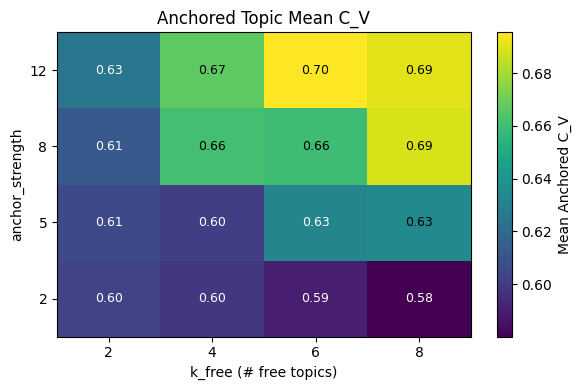

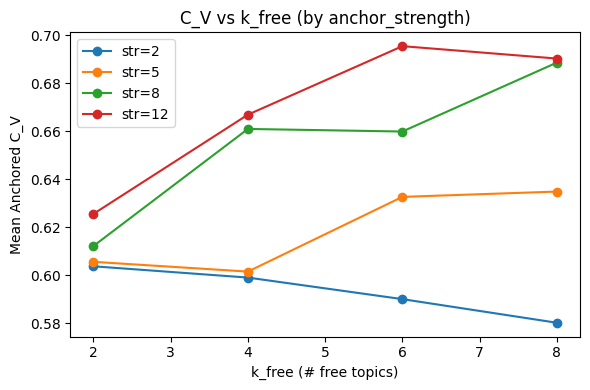

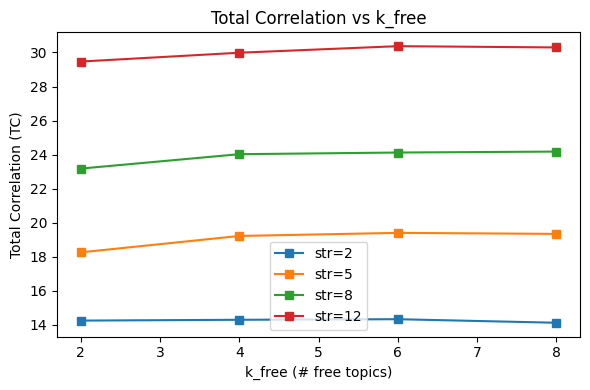

\nBest (by mean anchored C_V, tie-breaker lower k_free):\n k_free               6.000000
anchor_strength     12.000000
cv_anchored_mean     0.695399
cv_all_mean          0.619001
tc_total            30.371663
Name: 11, dtype: float64


In [55]:
# ---------- PLOTS ----------
pivot = df.pivot(index='anchor_strength', columns='k_free', values='cv_anchored_mean')

plt.figure(figsize=(6, 4))
plt.imshow(pivot.values, aspect='auto', origin='lower')
plt.colorbar(label='Mean Anchored C_V')
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xlabel('k_free (# free topics)')
plt.ylabel('anchor_strength')
plt.title('Anchored Topic Mean C_V')

for i, a_strength in enumerate(pivot.index):
    for j, k_free in enumerate(pivot.columns):
        val = pivot.loc[a_strength, k_free]
        plt.text(j, i, f"{val:.2f}", ha='center', va='center',
                 fontsize=9,
                 color='white' if val < pivot.values.mean() else 'black')

plt.tight_layout()
if SAVE_PLOTS:
    import os
    os.makedirs(OUTDIR, exist_ok=True)
    plt.savefig(f"{OUTDIR}/cv_heatmap.png", dpi=150)
plt.show()

# Line plot: C_V vs k_free for each anchor strength
plt.figure(figsize=(6, 4))
for a_strength in sorted(df.anchor_strength.unique()):
    sub = df[df.anchor_strength == a_strength].sort_values('k_free')
    plt.plot(sub.k_free, sub.cv_anchored_mean, marker='o', label=f'str={a_strength}')
plt.xlabel('k_free (# free topics)')
plt.ylabel('Mean Anchored C_V')
plt.title('C_V vs k_free (by anchor_strength)')
plt.legend()
plt.tight_layout()
if SAVE_PLOTS:
    plt.savefig(f"{OUTDIR}/cv_lines.png", dpi=150)
plt.show()

# Optional: TC vs k_free
if SHOW_TC_PLOT and not df['tc_total'].isna().all():
    plt.figure(figsize=(6, 4))
    for a_strength in sorted(df.anchor_strength.unique()):
        sub = df[df.anchor_strength == a_strength].sort_values('k_free')
        plt.plot(sub.k_free, sub.tc_total, marker='s', label=f'str={a_strength}')
    plt.xlabel('k_free (# free topics)')
    plt.ylabel('Total Correlation (TC)')
    plt.title('Total Correlation vs k_free')
    plt.legend()
    plt.tight_layout()
    if SAVE_PLOTS:
        plt.savefig(f"{OUTDIR}/tc_lines.png", dpi=150)
    plt.show()

# ---------- SIMPLE SELECTION ----------
best_row = df.sort_values(['cv_anchored_mean', 'k_free'],
                          ascending=[False, True]).iloc[0]
print("\\nBest (by mean anchored C_V, tie-breaker lower k_free):\\n", best_row)

### Clustering

In [65]:
selected_companies = ["Tesla", "Amazon", "FMC", "Apple", "Airbnb"]

filtered_selected_df = filtered_df[filtered_df["Company"].isin(selected_companies)].copy()
filtered_selected_df.head()

Company Ticker     Sector                         Industry  \
6354  Amazon   AMZN  Retailing  Internet Services and Retailing   
6360  Amazon   AMZN  Retailing  Internet Services and Retailing   
6361  Amazon   AMZN  Retailing  Internet Services and Retailing   
6362  Amazon   AMZN  Retailing  Internet Services and Retailing   
6364  Amazon   AMZN  Retailing  Internet Services and Retailing   

                                                   Text   Source  pred_topic  \
6354  in years, $targetedcompany will likely continu...  Twitter           1   
6360  targetedcompany canada $targetedcompany glad l...  Twitter           2   
6361  targetedcompany canada $targetedcompany ecobee...  Twitter           2   
6362  datawalk, a polish data analytics firm, inks d...  Twitter           2   
6364  portfolio & watchlist going into holdings: $ta...  Twitter           2   

      pred_prob pred_topic_name  
6354   0.999999          Health  
6360   0.999999         FinMkts  
6361   0.999999         FinMkts  
6362   0.999999         FinMkts  
6364   0.999999         FinMkts

#### Sentence Tokenization

In [62]:
# temp = docs_df.sample(n=1000, random_state=random_seed).copy()

# sentences_df = tokenize_sentences(docs_df, str("Text"))
sentence_tokenizations_allData_path = os.path.join(Data_path, "sentence_tokenizations_allData_df.csv")
sentences_df = pd.read_csv(sentence_tokenizations_allData_path)

In [66]:
sentences_df

original_idx                                           sentence
0                   0  $googl $goog $targetedcompany google and targe...
1                   1  can $phnix become the first meme coin to dethr...
2                   2  targetedcompany $targetedcompany the laughing ...
3                   3          some of the most iconic businesses ever .
4                   3                                 $mcd - mcdonalds .
...               ...                                                ...
2782418        591336                                million its holding
2782419        591337  clear channel outdoor hldgs $targetedcompany s...
2782420        591338  angelo gordon &amp; company lp maintains holdi...
2782421        591339  clear channel outdoor hldgs $targetedcompany s...
2782422        591340  clear channel outdoor hldgs $targetedcompany m...

[2782423 rows x 2 columns]

In [ ]:
# sentence_tokenizations_allData_path = os.path.join(Data_path, "sentence_tokenizations_allData_df.csv")
# sentences_df.to_csv(sentence_tokenizations_allData_path, index=False)

In [67]:
# Select sentences whose document exists in filtered_selected_df
selected_idxs = set(filtered_selected_df.index)
filtered_sentences = sentences_df[sentences_df['original_idx'].isin(selected_idxs)].copy()

# Map company and topic name from filtered_selected_df
filtered_sentences['Company'] = filtered_sentences['original_idx'].map(filtered_selected_df['Company'])
filtered_sentences['Topic_Name'] = filtered_sentences['original_idx'].map(filtered_selected_df['pred_topic_name'])

# Final DataFrame: sentence, company name, topic name
result_df = filtered_sentences[['sentence', 'Company', 'Topic_Name']]
result_df.head()

sentence Company Topic_Name
22686  in years, $targetedcompany will likely continu...  Amazon     Health
22687  heres a breakdown of how targetedcompany could...  Amazon     Health
22688  e-commerce expansion targetedcompanys dominanc...  Amazon     Health
22689  ubiquitous online shopping platform: targetedc...  Amazon     Health
22690  with its vast selection, fast delivery, and ev...  Amazon     Health

In [68]:
result_df.describe()

sentence Company Topic_Name
count    109546  109546     109546
unique    99153       5          5
top        | $.  Amazon     Health
freq        773   34357      37058

In [69]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np


In [71]:
embedder = SentenceTransformer('all-mpnet-base-v2')

sentences = result_df['sentence'].tolist()
embeddings = embedder.encode(sentences, batch_size=128, show_progress_bar=True)

Batches:   0%|          | 0/856 [00:00<?, ?it/s]

In [76]:
result_df["embedding"] = [emb.tolist() for emb in embeddings]

In [ ]:
path = os.path.join(Data_path, "embedded-topic-modeled-filtered-sentences.csv")
# result_df.to_csv(path)
result_df = pd.read_csv(path, index_col=0)

sentence Company Topic_Name  \
22686    in years, $targetedcompany will likely continu...  Amazon     Health   
22687    heres a breakdown of how targetedcompany could...  Amazon     Health   
22688    e-commerce expansion targetedcompanys dominanc...  Amazon     Health   
22689    ubiquitous online shopping platform: targetedc...  Amazon     Health   
22690    with its vast selection, fast delivery, and ev...  Amazon     Health   
...                                                    ...     ...        ...   
2128722  she is completely flawed, arrogant beyond doub...     FMC    CustRev   
2128723  i have been a little disappointed on the lack ...     FMC    CustRev   
2128724                                      i dont agree!     FMC    CustRev   
2128725  tldr: if you havent yet read the series, i wou...     FMC    CustRev   
2128726  up for any reccs as well with fmcs like sadie,...     FMC    CustRev   

                                                 embedding  
22686    [0.029284602031111717, 0.0638408288359642, -0....  
22687    [0.0190665852278471, 0.014945215545594692, -0....  
22688    [0.04830900952219963, -0.016045119613409042, -...  
22689    [0.052670903503894806, -0.043732982128858566, ...  
22690    [0.0010637782979756594, 0.02155088447034359, -...  
...                                                    ...  
2128722  [-0.07115577906370163, 0.11065994948148727, 0....  
2128723  [0.030578266829252243, 0.034365709871053696, -...  
2128724  [-0.024434970691800117, 0.11243941634893417, 0...  
2128725  [-0.002316732658073306, -0.002310855081304908,...  
2128726  [0.07659560441970825, -0.008427856490015984, 0...  

[109546 rows x 4 columns]

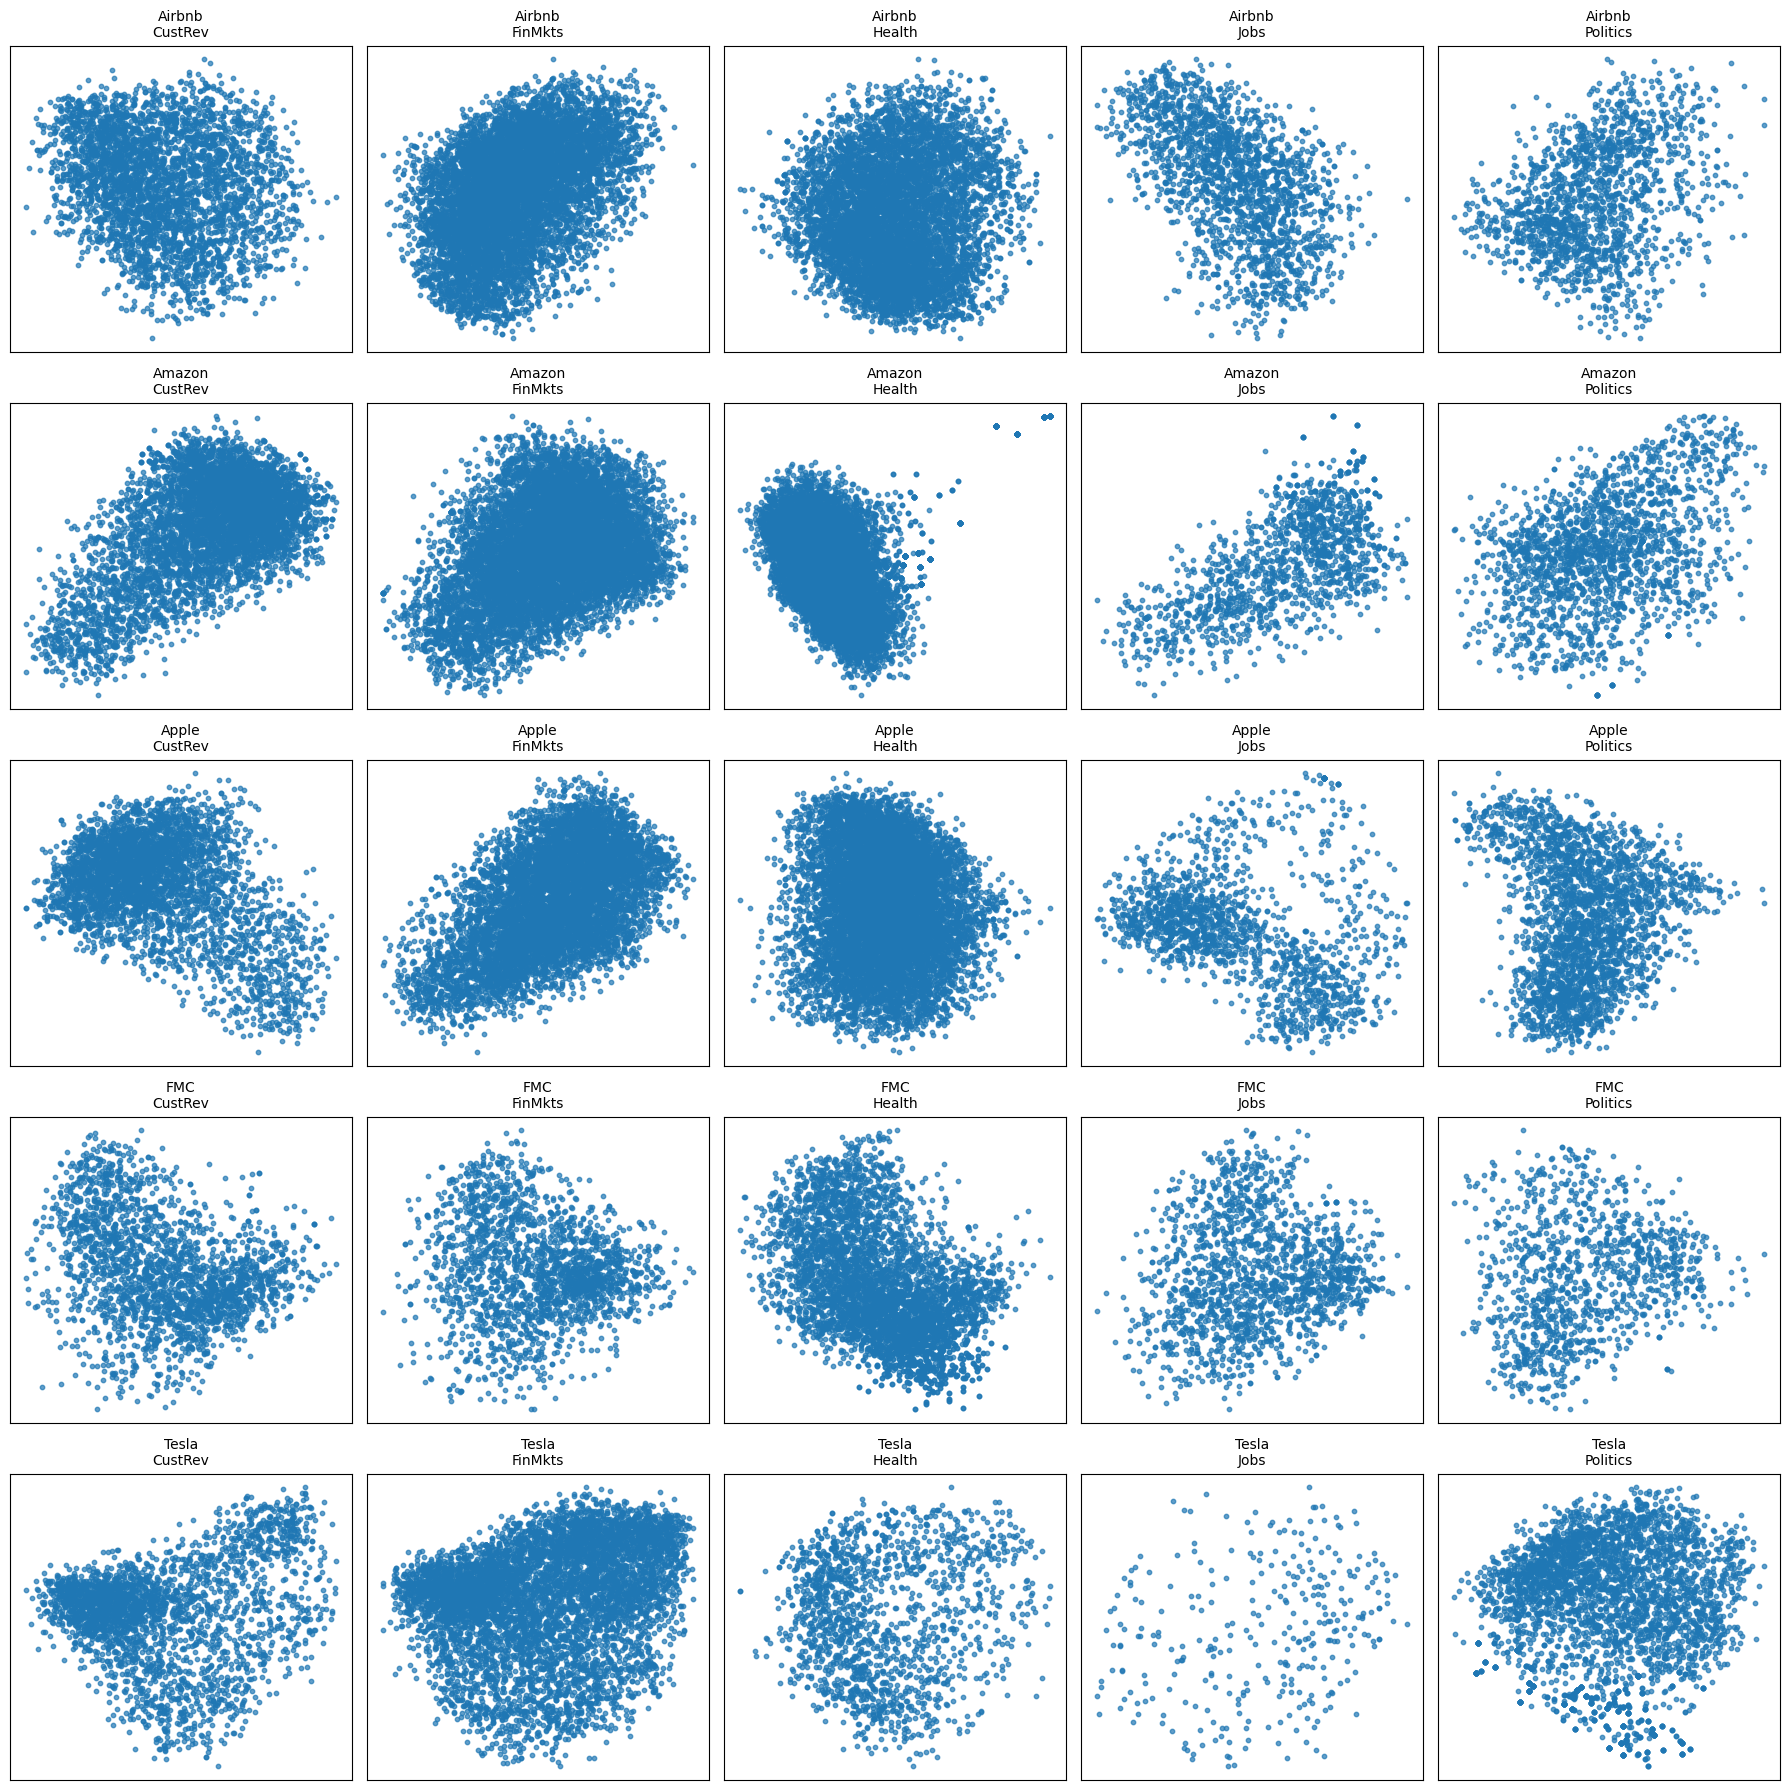

In [99]:
import numpy as np
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt

# Get all unique (Company, Topic_Name) pairs
groups = list(result_df.groupby(['Company', 'Topic_Name']))

fig, axes = plt.subplots(5, 5, figsize=(18, 18))
axes = axes.flatten()

for idx, ((company, topic), group) in enumerate(groups[:25]):
    # Prepare embeddings matrix
    X = np.vstack(group['embedding'].to_list())
    # SVD to 2D
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(X)
    ax = axes[idx]
    ax.scatter(X_2d[:, 0], X_2d[:, 1], s=10, alpha=0.7)
    ax.set_title(f"{company}\n{topic}", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

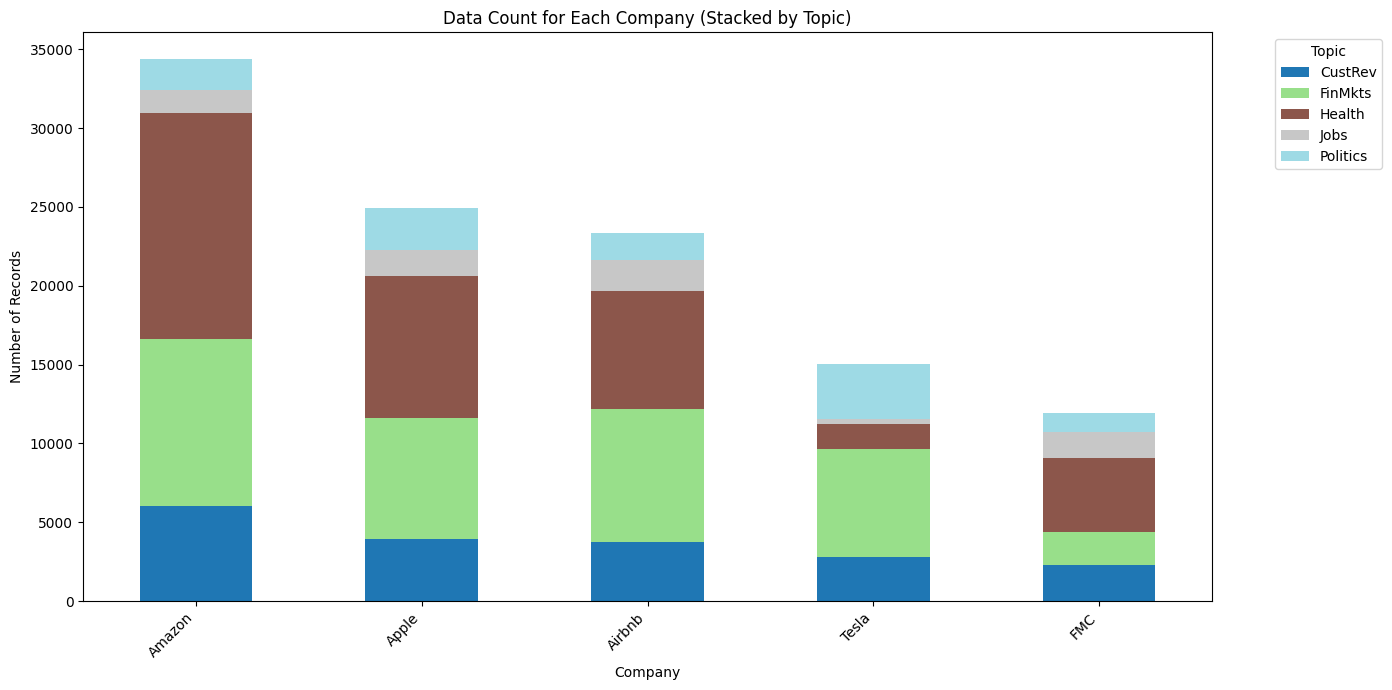

In [84]:
# Prepare data for stacked bar chart: Company vs. Topic counts
company_topic_counts = (
    result_df.groupby(['Company', 'Topic_Name'])
    .size()
    .unstack(fill_value=0)
)

# Select top N companies for readability (e.g., top 20 by total count)
top_n = 20
top_companies = company_topic_counts.sum(axis=1).sort_values(ascending=False).head(top_n).index
plot_data = company_topic_counts.loc[top_companies]

# Plot
plt.figure(figsize=(14, 7))
plot_data.plot(kind='bar', stacked=True, colormap='tab20', ax=plt.gca())
plt.title('Data Count for Each Company (Stacked by Topic)')
plt.xlabel('Company')
plt.ylabel('Number of Records')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

KMeans (Amazon):   0%|          | 0/5 [00:00<?, ?topic/s]

Topic_Name  n_sentences  chosen_k  silhouette  n_after_merge  \
0    CustRev         6051         2    0.073285              2   
1    FinMkts        10587         9    0.066286              9   
2     Health        14312         2    0.215123              2   
3       Jobs         1460         2    0.077293              2   
4   Politics         1947        10    0.101582             10   

   min_cluster_size_post  
0                      2  
1                      2  
2                      2  
3                      2  
4                      2

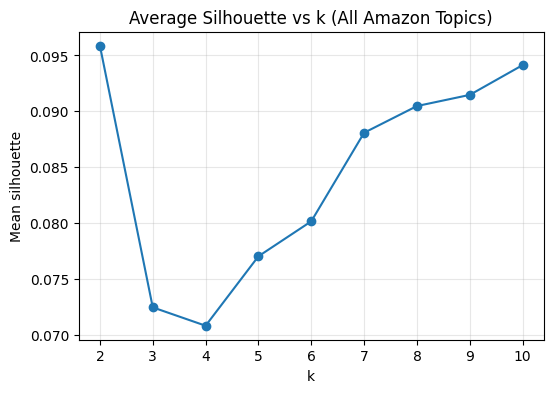

ValueError: x and y must be the same size

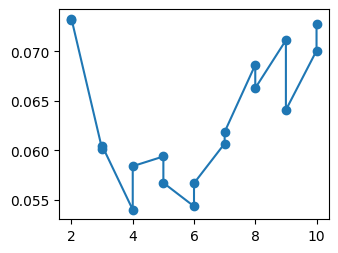

In [ ]:
# ONE-CELL: AUTOMATED KMEANS PIPELINE (Amazon-only, raw embeddings, silhouette-based k selection)
# -----------------------------------------------------------------------------------------------
# Requirements (install if needed):
# !pip install tqdm scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# ================================== CONFIG ===================================
COMPANY_NAME = "Amazon"
EMBED_COL = "embedding"              # column containing embedding (list/array)
TEXT_COL = "sentence"

K_MAX = 10                           # hard ceiling for search range (per topic)
MIN_SAMPLES_FOR_CLUSTERING = 5       # below this => k=1
SILHOUETTE_THRESHOLD = 0.05          # if best silhouette < threshold => k=1
TRY_INITS = ["k-means++", "random"]  # init strategies to try
TRY_N_INIT = [10]                    # list of n_init values to explore (scikit-learn >=1.4 you can also use "auto")
RANDOM_STATE = 42

USE_PCA = True                       # Set False to disable PCA before clustering
PCA_COMPONENTS = 50                  # number of components *during clustering* (not for final visualization)
PCA_VARIANCE_CUTOFF = 0.95           # if not None: keep min(#comp) explaining this variance (bounded by PCA_COMPONENTS)

PCA_FOR_PLOT = True                  # If True project clustered points to 2D PCA for plots
MIN_CLUSTER_SIZE_POST = 2            # post-processing: merge clusters smaller than this into nearest larger cluster (set to 1 to disable)
MERGE_TINY_BY = "centroid"           # strategy: 'centroid' distance (euclidean in reduced space if PCA used)

REPRESENTATIVE_STRATEGY = "centroid" # 'centroid' or 'closest_first' (same result usually)
SHOW_PROGRESS = True
VERBOSE = True

GRID_PAGE_SIZE = 25                  # 5x5 subplots
MAX_PAGES = None                     # None = all
FIGSIZE_PER_PAGE = (15,15)

# ============================== HELPER FUNCTIONS =============================

def prepare_matrix(group_df):
    """Stack embeddings (raw, unmodified)."""
    X = np.vstack(group_df[EMBED_COL].to_list()).astype(float)
    return X

def maybe_pca_fit_transform(X):
    """Optional PCA for clustering step."""
    if not USE_PCA or X.shape[1] <= PCA_COMPONENTS:
        return X, None
    pca = PCA(n_components=min(PCA_COMPONENTS, X.shape[1]), random_state=RANDOM_STATE)
    Xr = pca.fit_transform(X)
    if PCA_VARIANCE_CUTOFF is not None:
        # Determine minimum components to reach variance cutoff
        cum = np.cumsum(pca.explained_variance_ratio_)
        m = np.searchsorted(cum, PCA_VARIANCE_CUTOFF) + 1
        if m < Xr.shape[1]:
            Xr = Xr[:, :m]
    return Xr, pca

def choose_k_and_params(Xr, k_max, try_inits, try_n_init):
    """Grid search over k, init, n_init; maximize silhouette."""
    n = Xr.shape[0]
    upper_k = min(k_max, n - 1)  # silhouette needs k < n
    trials = []
    best = {'silhouette': -1}
    for k in range(2, upper_k + 1):
        for init in try_inits:
            for n_init in try_n_init:
                km = KMeans(n_clusters=k, init=init, n_init=n_init, random_state=RANDOM_STATE)
                labels = km.fit_predict(Xr)
                # We only compute silhouette if >1 cluster and at least one sample per cluster
                if len(set(labels)) < 2 or len(set(labels)) == n:
                    continue
                sil = silhouette_score(Xr, labels)
                trials.append({'k': k, 'init': init, 'n_init': n_init, 'silhouette': sil})
                if sil > best['silhouette']:
                    best = {'k': k, 'init': init, 'n_init': n_init, 'silhouette': sil, 'labels': labels, 'model': km}
    trials_df = pd.DataFrame(trials)
    if trials_df.empty or best['silhouette'] < SILHOUETTE_THRESHOLD:
        # fallback single cluster
        best = {'k': 1, 'init': None, 'n_init': None, 'silhouette': np.nan,
                'labels': np.zeros(n, dtype=int), 'model': None}
    return best, trials_df

def merge_tiny_clusters(Xr, labels, min_size=2, strategy="centroid"):
    """
    Merge clusters smaller than min_size into nearest large cluster.
    Xr: feature space used for clustering (PCA-reduced or raw).
    """
    if min_size <= 1:
        return labels  # nothing to do
    labels = labels.copy()
    unique = sorted(set(labels))
    # Build cluster members
    cluster_indices = {c: np.where(labels == c)[0] for c in unique}
    small = [c for c, ix in cluster_indices.items() if len(ix) < min_size and len(ix) > 0]
    if not small or len(unique) == 1:
        return labels
    # Compute centroids
    centroids = {c: Xr[ix].mean(axis=0) for c, ix in cluster_indices.items()}
    large = [c for c in unique if c not in small]
    if not large:
        return labels  # all are small -> leave as is
    for sc in small:
        sc_cent = centroids[sc]
        # find nearest large cluster by Euclidean distance
        dists = [(lc, np.linalg.norm(sc_cent - centroids[lc])) for lc in large]
        target = min(dists, key=lambda t: t[1])[0]
        labels[labels == sc] = target
        # update centroid target
        combined_ix = np.where(labels == target)[0]
        centroids[target] = Xr[combined_ix].mean(axis=0)
    # Re-label to consecutive integers
    old_labels = sorted(set(labels))
    remap = {c:i for i,c in enumerate(old_labels)}
    return np.vectorize(remap.get)(labels)

def compute_representatives(Xr, labels, original_index, strategy="centroid"):
    reps = []
    for c in sorted(set(labels)):
        mask = labels == c
        idxs = np.where(mask)[0]
        if strategy == "closest_first":
            reps.append(original_index[idxs[0]])
            continue
        # centroid strategy
        centroid = Xr[mask].mean(axis=0)
        dists = np.linalg.norm(Xr[mask] - centroid, axis=1)
        best_local = idxs[np.argmin(dists)]
        reps.append(original_index[best_local])
    return set(reps)

def project_for_plot(X):
    if not PCA_FOR_PLOT:
        # If dimension > 2, just take first two columns
        Y = X[:, :2] if X.shape[1] >= 2 else np.hstack([X, np.zeros((X.shape[0], 2 - X.shape[1]))])
        return Y
    if X.shape[1] <= 2:
        if X.shape[1] == 1:
            return np.hstack([X, np.zeros((X.shape[0],1))])
        return X
    pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
    return pca2.fit_transform(X)

# ============================= MAIN PIPELINE =================================

def cluster_amazon_kmeans(result_df):
    df_amz = result_df[result_df['Company'] == COMPANY_NAME].copy()
    if df_amz.empty:
        raise ValueError(f"No rows for Company == {COMPANY_NAME}")
    df_amz['Topic_Name'] = df_amz['Topic_Name'].astype(str).str.strip()

    summary_rows = []
    tuning_rows = []
    clustered_frames = []
    topics = sorted(df_amz['Topic_Name'].unique())
    iterator = tqdm(topics, disable=not SHOW_PROGRESS, desc=f"KMeans ({COMPANY_NAME})", unit="topic")

    for topic in iterator:
        grp = df_amz[df_amz['Topic_Name'] == topic].copy()
        n = len(grp)
        if n < 2:
            # single point or empty -> trivial cluster
            grp['cluster'] = 0
            grp['is_representative'] = True
            grp['plot_x'] = 0.0
            grp['plot_y'] = 0.0
            summary_rows.append({
                "Topic_Name": topic,
                "n_sentences": n,
                "chosen_k": 1,
                "silhouette": np.nan,
                "n_after_merge": 1,
                "min_cluster_size_post": MIN_CLUSTER_SIZE_POST
            })
            clustered_frames.append(grp)
            continue

        X = prepare_matrix(grp)

        # Optional PCA for clustering
        Xr, pca_model = maybe_pca_fit_transform(X)
        # Choose k
        if n < MIN_SAMPLES_FOR_CLUSTERING:
            labels = np.zeros(n, dtype=int)
            best_sil = np.nan
            best_k = 1
            trials_df = pd.DataFrame(columns=['k','init','n_init','silhouette'])
        else:
            best, trials_df = choose_k_and_params(Xr, K_MAX, TRY_INITS, TRY_N_INIT)
            labels = best['labels']
            best_sil = best['silhouette']
            best_k = best['k']
        # Post-processing: merge tiny clusters
        labels_merged = merge_tiny_clusters(Xr, labels, min_size=MIN_CLUSTER_SIZE_POST)
        n_after_merge = len(set(labels_merged))
        # Representatives (on reduced space Xr)
        rep_indices = compute_representatives(Xr, labels_merged, grp.index.values, strategy=REPRESENTATIVE_STRATEGY)

        grp['cluster'] = labels_merged
        grp['is_representative'] = grp.index.isin(rep_indices)

        # 2D projection for plotting (we use Xr for visual if PCA was applied; else raw X)
        plot_base = Xr if USE_PCA else X
        plot_xy = project_for_plot(plot_base)
        grp['plot_x'] = plot_xy[:,0]
        grp['plot_y'] = plot_xy[:,1]

        # Summary entries
        summary_rows.append({
            "Topic_Name": topic,
            "n_sentences": n,
            "chosen_k": best_k,
            "silhouette": best_sil,
            "n_after_merge": n_after_merge,
            "min_cluster_size_post": MIN_CLUSTER_SIZE_POST
        })
        # Store tuning details
        if not trials_df.empty:
            trials_df = trials_df.copy()
            trials_df['Topic_Name'] = topic
            tuning_rows.append(trials_df)

        clustered_frames.append(grp)

        if VERBOSE:
            iterator.set_postfix(topic=topic[:18],
                                 k=best_k,
                                 sil="nan" if np.isnan(best_sil) else f"{best_sil:.2f}",
                                 merged=n_after_merge)

    clustered_df = pd.concat(clustered_frames, ignore_index=True) if clustered_frames else pd.DataFrame()
    summary_df = pd.DataFrame(summary_rows)
    tuning_df = pd.concat(tuning_rows, ignore_index=True) if tuning_rows else pd.DataFrame(
        columns=['k','init','n_init','silhouette','Topic_Name'])
    return clustered_df, summary_df, tuning_df

# ================================ VISUALS ====================================

def plot_k_silhouette_overall(tuning_df):
    if tuning_df.empty:
        print("No tuning trials to plot.")
        return
    agg = tuning_df.groupby('k')['silhouette'].mean()
    plt.figure(figsize=(6,4))
    plt.plot(agg.index, agg.values, marker='o')
    plt.title("Average Silhouette vs k (All Amazon Topics)")
    plt.xlabel("k")
    plt.ylabel("Mean silhouette")
    plt.grid(alpha=0.3)
    plt.show()

def plot_k_silhouette_per_topic(tuning_df, summary_df):
    if tuning_df.empty:
        print("No tuning trials to plot.")
        return
    topics = tuning_df['Topic_Name'].unique()
    cols = 4
    rows = int(np.ceil(len(topics)/cols))
    plt.figure(figsize=(4*cols, 3*rows))
    for i, topic in enumerate(topics, 1):
        ax = plt.subplot(rows, cols, i)
        g = tuning_df[tuning_df['Topic_Name']==topic]
        ax.plot(g['k'], g['silhouette'], marker='o')
        chosen = summary_df.loc[summary_df['Topic_Name']==topic, 'chosen_k']
        if not chosen.empty and chosen.iloc[0] > 1:
            k_sel = chosen.iloc[0]
            sil_sel = g.loc[g['k']==k_sel, 'silhouette']
            if not sil_sel.empty:
                ax.scatter([k_sel], sil_sel, s=70, edgecolor='k', zorder=5)
        ax.set_title(topic[:22], fontsize=9)
        ax.set_xlabel("k")
        ax.set_ylabel("sil.")
        ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_cluster_scatter_pages(clustered_df, max_per_page=25, max_pages=None):
    if clustered_df.empty:
        print("No clustered data.")
        return
    groups = list(clustered_df.groupby("Topic_Name"))
    page = 0
    while page * max_per_page < len(groups):
        if max_pages is not None and page >= max_pages:
            print(f"Reached page limit {max_pages}.")
            break
        subset = groups[page*max_per_page:(page+1)*max_per_page]
        fig = plt.figure(figsize=FIGSIZE_PER_PAGE)
        for i, (topic, g) in enumerate(subset, 1):
            ax = fig.add_subplot(5,5,i)
            sc = ax.scatter(g['plot_x'], g['plot_y'], c=g['cluster'], s=25, cmap='tab20', alpha=0.85)
            # Centroids
            centroids = g.groupby('cluster')[['plot_x','plot_y']].mean()
            ax.scatter(centroids['plot_x'], centroids['plot_y'], marker='X', s=80, c='black')
            ax.set_title(f"{topic[:20]} (k={g['cluster'].nunique()})", fontsize=8)
            ax.set_xticks([]); ax.set_yticks([])
        fig.suptitle(f"Amazon Topic Clusters Page {page+1}", fontsize=14)
        plt.tight_layout(rect=[0,0,1,0.95])
        plt.show()
        page += 1

# =============================== USAGE EXAMPLE ===============================
clustered_df, summary_df, tuning_df = cluster_amazon_kmeans(result_df)


In [119]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# -------------------------------------------------------------
# 1. Overall silhouette vs k
# -------------------------------------------------------------
def plot_k_silhouette_overall(tuning_df, agg='mean'):
    """
    Plot aggregated silhouette vs k across all topics.
    Parameters
    ----------
    tuning_df : DataFrame with at least ['k','silhouette']
    agg : 'mean' or 'max' aggregation across different init/n_init trials
    """
    if tuning_df.empty:
        print("No tuning trials to plot.")
        return
    if agg == 'max':
        series = tuning_df.groupby('k')['silhouette'].max()
    else:
        series = tuning_df.groupby('k')['silhouette'].mean()
    plt.figure(figsize=(6,4))
    plt.plot(series.index, series.values, marker='o')
    plt.title(f"Aggregate Silhouette vs k ({agg})")
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.grid(alpha=0.3)
    plt.show()

# -------------------------------------------------------------
# 2. Per-topic silhouette curves (FIXED)
# -------------------------------------------------------------
def plot_k_silhouette_per_topic(tuning_df, summary_df, agg='mean', cols=4, max_topics=None):
    """
    Per-topic silhouette curves.
    
    Parameters
    ----------
    tuning_df : DataFrame with columns ['Topic_Name','k','silhouette', ...]
    summary_df: DataFrame with columns ['Topic_Name','chosen_k', ...]
    agg : 'mean' or 'max' for curve aggregation across different trials of same k
    cols : number of subplot columns
    max_topics : limit number of topics to plot (for speed) or None = all
    """
    if tuning_df.empty:
        print("No tuning trials to plot.")
        return

    topics = sorted(tuning_df['Topic_Name'].unique())
    if max_topics is not None:
        topics = topics[:max_topics]
    n_topics = len(topics)
    rows = math.ceil(n_topics / cols)
    plt.figure(figsize=(4*cols, 3*rows))

    # Pre-build map of chosen k per topic
    chosen_map = dict(zip(summary_df['Topic_Name'], summary_df['chosen_k']))

    for i, topic in enumerate(topics, 1):
        ax = plt.subplot(rows, cols, i)
        g = tuning_df[tuning_df['Topic_Name'] == topic]
        if g.empty:
            ax.set_title(topic[:22])
            ax.axis('off')
            continue

        # Aggregate curve across multiple init/n_init trials per k
        if agg == 'max':
            curve = g.groupby('k')['silhouette'].max()
        else:
            curve = g.groupby('k')['silhouette'].mean()

        ax.plot(curve.index, curve.values, marker='o')

        k_sel = chosen_map.get(topic, None)
        if k_sel is not None and k_sel > 1:
            sil_candidates = g.loc[g['k'] == k_sel, 'silhouette']
            if not sil_candidates.empty:
                sil_value = float(sil_candidates.max())
                ax.scatter([k_sel], [sil_value], s=80, edgecolor='k', facecolor='gold', zorder=5)

        ax.set_title(topic[:22], fontsize=9)
        ax.set_xlabel("k")
        ax.set_ylabel("sil.")
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------
# 3. Cluster scatter pages (5x5 grid)
# -------------------------------------------------------------
def plot_cluster_scatter_pages(clustered_df,
                               max_per_page=25,
                               max_pages=None,
                               show_centroids=True,
                               figsize=(15,15),
                               title_prefix="Amazon Topic Clusters"):
    """
    Paginated scatter plots of clusters per topic (columns: plot_x, plot_y).
    
    clustered_df requires columns:
      - Topic_Name
      - cluster
      - plot_x
      - plot_y
    """
    required_cols = {'Topic_Name','cluster','plot_x','plot_y'}
    if not required_cols.issubset(clustered_df.columns):
        missing = required_cols - set(clustered_df.columns)
        raise ValueError(f"clustered_df missing required columns: {missing}")

    groups = list(clustered_df.groupby("Topic_Name"))
    if not groups:
        print("No clustered data to visualize.")
        return

    page = 0
    while page * max_per_page < len(groups):
        if max_pages is not None and page >= max_pages:
            print(f"Reached page limit ({max_pages}).")
            break
        subset = groups[page*max_per_page:(page+1)*max_per_page]
        fig = plt.figure(figsize=figsize)
        for i, (topic, g) in enumerate(subset, 1):
            ax = fig.add_subplot(5,5,i)
            scatter = ax.scatter(g['plot_x'], g['plot_y'],
                                 c=g['cluster'], s=25, cmap='tab20', alpha=0.85)
            if show_centroids:
                centroids = g.groupby('cluster')[['plot_x','plot_y']].mean()
                ax.scatter(centroids['plot_x'], centroids['plot_y'],
                           marker='X', s=80, c='black')
            ax.set_title(f"{topic[:20]} (k={g['cluster'].nunique()})", fontsize=8)
            ax.set_xticks([]); ax.set_yticks([])
        fig.suptitle(f"{title_prefix} Page {page+1}", fontsize=14)
        plt.tight_layout(rect=[0,0,1,0.95])
        plt.show()
        page += 1

# -------------------------------------------------------------
# 4. Cluster size distribution (non-noise; for k-means all points counted)
# -------------------------------------------------------------
def plot_cluster_size_distribution(clustered_df):
    if clustered_df.empty:
        print("Empty clustered_df.")
        return
    size_df = (clustered_df
               .groupby(['Topic_Name','cluster'])
               .size()
               .reset_index(name='size'))
    plt.figure(figsize=(8,5))
    plt.hist(size_df['size'], bins=20)
    plt.xlabel("Cluster Size")
    plt.ylabel("Count")
    plt.title("Distribution of Cluster Sizes (All Topics)")
    plt.grid(alpha=0.3)
    plt.show()

# -------------------------------------------------------------
# 5. Clusters per topic (bar plot)
# -------------------------------------------------------------
def plot_topic_cluster_counts(clustered_df):
    if clustered_df.empty:
        print("Empty clustered_df.")
        return
    counts = (clustered_df.groupby('Topic_Name')['cluster']
              .nunique()
              .reset_index(name='cluster_count')
              .sort_values('cluster_count', ascending=False))
    plt.figure(figsize=(8, 0.4*len(counts) + 2))
    plt.barh(counts['Topic_Name'], counts['cluster_count'])
    plt.xlabel("Number of Clusters")
    plt.title("Clusters per Topic")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------
# 6. Representative sentences table (utility)
# -------------------------------------------------------------
def show_representative_sentences(clustered_df, topic=None, max_per_topic=3, text_col='sentence'):
    """
    Print representative sentences (flag is_representative == True).
    Optionally filter to one topic.
    """
    if 'is_representative' not in clustered_df.columns:
        raise ValueError("'is_representative' column not found.")
    df = clustered_df[clustered_df['is_representative']]
    if topic:
        df = df[df['Topic_Name'] == topic]
        if df.empty:
            print(f"No representatives for topic '{topic}'.")
            return
    # Limit per topic
    df = (df.sort_values(['Topic_Name','cluster'])
            .groupby(['Topic_Name','cluster'])
            .head(1))  # one per cluster
    if max_per_topic is not None:
        df = df.groupby('Topic_Name').head(max_per_topic)
    display(df[['Topic_Name','cluster', text_col]])


Topic_Name  n_sentences  chosen_k  silhouette  n_after_merge  \
0    CustRev         6051         2    0.073285              2   
1    FinMkts        10587         9    0.066286              9   
2     Health        14312         2    0.215123              2   
3       Jobs         1460         2    0.077293              2   
4   Politics         1947        10    0.101582             10   

   min_cluster_size_post  
0                      2  
1                      2  
2                      2  
3                      2  
4                      2

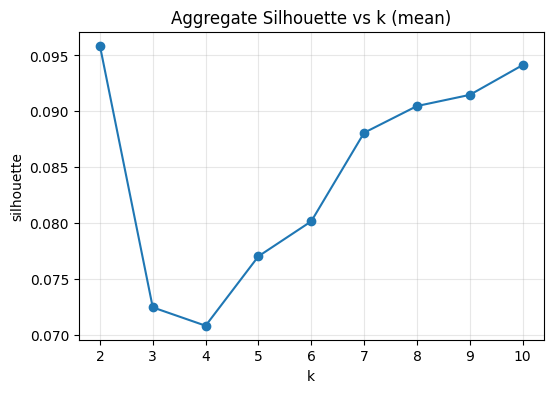

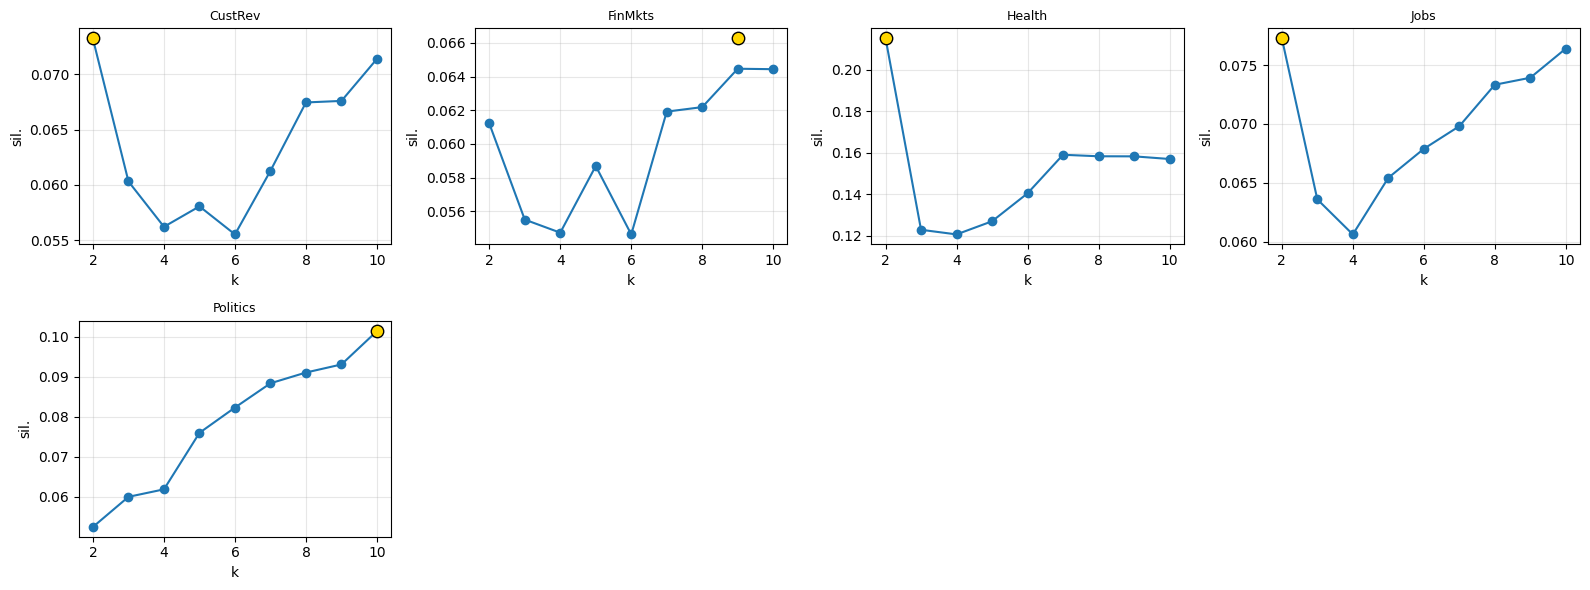

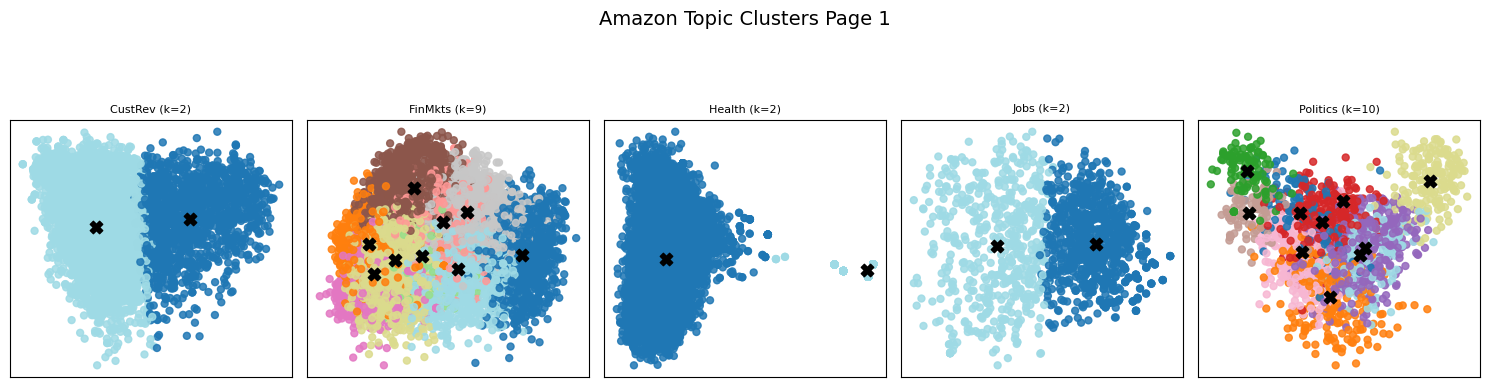

Topic_Name  cluster                                           sentence
91      CustRev        1                                               lol.
1134    CustRev        0                    ct sellscheap garbage products.
6597    FinMkts        4                                           fuk hem.
7316    FinMkts        0  edit: thredup is not an targetedcompany compan...
9122    FinMkts        2  awd-it **memory** | [corsair vengeance gb ( x ...

In [120]:
display(summary_df.head())
plot_k_silhouette_overall(tuning_df)
plot_k_silhouette_per_topic(tuning_df, summary_df)
plot_cluster_scatter_pages(clustered_df, max_per_page=GRID_PAGE_SIZE, max_pages=MAX_PAGES)
# Representatives:
reps = clustered_df[clustered_df.is_representative][['Topic_Name','cluster', TEXT_COL]]
display(reps.head())

In [130]:
import textwrap

def show_cluster_samples(df, topics=None, clusters_per_topic=None, samples_per_cluster=50, wrap_width=100, random_seed=42):
    """
    Print wrapped sentences for each topic and cluster.
    Parameters:
        df: DataFrame with columns ['Topic_Name', 'cluster', 'sentence']
        topics: list of topics to include (default: all)
        clusters_per_topic: max clusters per topic (default: all)
        samples_per_cluster: max samples per cluster
        wrap_width: width for textwrap
        random_seed: for reproducibility
    """
    if topics is None:
        topics = sorted(df['Topic_Name'].unique())
    for topic in topics:
        topic_df = df[df['Topic_Name'] == topic]
        clusters = sorted(topic_df['cluster'].unique())
        if clusters_per_topic is not None:
            clusters = clusters[:clusters_per_topic]
        print(f"\n{'='*80}\nTopic: {topic}\n{'='*80}")
        for cluster_id in clusters:
            cluster_df = topic_df[topic_df['cluster'] == cluster_id]
            samples = cluster_df.sample(n=min(50, len(cluster_df)), random_state=random_seed)
            print(f"\n--- Cluster {cluster_id} ({len(cluster_df)} sentences) ---")
            for idx, row in samples.iterrows():
                wrapped = textwrap.fill(str(row['sentence']), width=wrap_width)
                print(f"- {wrapped}\n")

show_cluster_samples(clustered_df, samples_per_cluster=50, wrap_width=100)


Topic: CustRev

--- Cluster 0 (1477 sentences) ---
- targetedcompany \*\*cpu cooler\*\* | \[thermalright peerless assassin se .

- even buying rd party seller off of best buy or walmart sometimes the item just ends up coming from
targetedcompany.

- i luckily was able to find it and videoed myself through the entire return process because i just
had a horrible feeling about this company.

- the targetedcompany product was watery and ran easily.

- sometimes, i'm able to shop grocery deals online and get pickup (for free) at the store.

- for your usage of targetedcompany flipkart myntra swiggy zomato - swiggy hdfc cc is the best.

- shop a curated box]( now all the items are linked properly!

- if the customer watches just seconds of that one and then clicks out because it's awful, ***who gets
paid if they buy***?

- explore top rated horse cross ties on targetedcompany.]](

- is off topic so the aim of this post is just to educate people on how to shop for authentic
products: make su

In [86]:
# Show 50 samples of each cluster for each combo of Amazon and topic
for topic, topic_df in cluster_results.items():
    print(f"\n=== Topic: {topic} ===")
    for cluster_id in sorted(topic_df['cluster'].unique()):
        print(f"\n--- Cluster {cluster_id} ---")
        samples = topic_df[topic_df['cluster'] == cluster_id].sample(n=min(50, len(topic_df[topic_df['cluster'] == cluster_id])), random_state=random_seed)
        for idx, row in samples.iterrows():
            print(f"{row['sentence']}")


=== Topic: Politics ===

--- Cluster 0 ---
don't let someone fool you into thinking you imagined things.
although their 'large' is generous, extra-large breeds may require the xxl dog bed.**.
for those of you without a village, i totally commiserate with you.
i reached out to mods again who passed on the info for me but didnt hear anything from him, and said its up to jj to respond (fair imo) (img ).
the woman had put down her book and smiled, hi katie, glad you could join us.
whether youre flying halfway across the globe or driving to a nearby town, the experiences and people met turn each journey into a collection of stories.
trump and his minions lied to the maga people.**
i look forward to hearing from you soon.
they can be the perfect companion on your travels, pushing you to explore hidden gems and experience the world with a sense of awe and wonder.
i have to credit an amazing teacher of mine for making me aware of this stuff - andrew bartzis the galactic historian.
join me!
if